In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os
import random
from google.colab import files
from zipfile import ZipFile
import math

In [ ]:
uploaded = files.upload()
with ZipFile('/content/dataset.zip') as zip:
    zip.extractall()

Saving dataset.zip to dataset.zip


In [ ]:
names = list(os.walk('/content/not_smoking'))[0][2]
dataset = []
for i in names:
    path = '/content/not_smoking/' + i
    dataset.append([torchvision.io.read_image(path).float(), torch.tensor(0.)])

names = list(os.walk('/content/smoking'))[0][2]
for i in names:
    path = '/content/smoking/' + i
    dataset.append([torchvision.io.read_image(path).float(), torch.tensor(1.)])

random.seed(1000)
random.shuffle(dataset)

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, img_transform=None, label_transform=None):
        ''' data have format (image, label)'''
        self.data = data
        self.img_t = img_transform
        self.label_t = label_transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]
        if self.img_t:
            data[0] = self.img_t(data[0])
        if self.label_t:
            data[1] = self.label_t(data[1])
        return data

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(3, 1, 1)
        self.conv1 = nn.Conv2d(1, 3, 3)
        self.conv2 = nn.Conv2d(3, 9, 4)
        self.conv3 = nn.Conv2d(9, 27, 3)
        self.conv4 = nn.Conv2d(27, 81, 3)
        self.norm5 = nn.BatchNorm2d(81)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(81 * 12 * 12, 150)
        self.norm6 = nn.BatchNorm1d(150)
        self.fc2 = nn.Linear(150, 1)
        self.drop = nn.Dropout(p=0.8)

    def forward(self, x):
        x = self.conv0(x)
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = F.relu(self.pool(self.conv3(x)))
        x = F.relu(self.pool(self.conv4(x)))
        x = self.norm5(x)
        x = x.view(-1, 81 * 12 * 12)
        x = F.relu(self.fc1(self.drop(x)))
        x = self.norm6(x)
        x = self.fc2(self.drop(x))
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

class CANet(nn.Module):
    def __init__(self):
        super().__init__()
        self.transform = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        self.conv1 = nn.Conv2d(3, 3, 3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        for i in range(len(x)):
            x[i] = self.transform(x[i])
        return x

def get_loader(data, split, batch, test=False):

    transform = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    
    idx = 0
    index = []
    for i in split:
        idx += int(len(data)*i)
        index.append(idx)

    if test:
        dataset = Dataset(data[index[1]:], transform)
        loader = torch.utils.data.DataLoader(
            dataset, batch_size=len(dataset), num_workers=1)
        return loader

    dataset = Dataset(data[:index[0]], transform)
    sampler = SubsetRandomSampler(range(0, len(dataset)))
    train_l = torch.utils.data.DataLoader(
        dataset, batch_size=batch, num_workers=1, sampler=sampler)
    
    dataset = Dataset(data[index[0]:index[1]], transform)
    sampler = SubsetRandomSampler(range(0, len(dataset)))
    val_l = torch.utils.data.DataLoader(
        dataset, batch_size=len(dataset), num_workers=1)
    
    return train_l, val_l


def checks(net, sample=0.1, batch=64, lr=0.001, epochs=10):
    '''Sanity checks. Probably just a temporary function'''
    pass

def evaluate(net, loader, criterion):
    err = 0
    losst = 0
    pictures = 0
    for i, data in enumerate(loader, 1):
        inputs, labels = data

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        err += (torch.sigmoid(outputs).squeeze().round().int() != labels).sum()
        losst += loss.item()
        pictures += len(labels)
    return err/pictures, losst/i

def train(net, data, split=(0.6,0.2,0.2), name='net', batch=64, lr=0.001, epochs=10):
    global errors_t, losses_t, errors_v, losses_v
    torch.manual_seed(1000)
    random.seed(1000)
    train_l, val_l = get_loader(data, split, batch)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(net[1].parameters(), lr=lr[1], weight_decay=0.015, amsgrad=True)

    err_v, loss_v = evaluate(net[1], train_l, criterion)
    errors_t.append(err_v)
    losses_t.append(loss_v)
    print(f'Epoch 0 | Error: {err_v} |', f'Loss: {loss_v}')
    for epoch in range(epochs):

        err = 0
        losst = 0
        pictures = 0
        
        for i, data in enumerate(train_l, 1):
            inputs, labels = data

            optimizer.zero_grad()
            net[1].train()
            outputs = net[1](inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            err += (torch.sigmoid(outputs).squeeze().round().int() != labels).sum()
            losst += loss.item()
            pictures += len(labels)
            
        net[1].eval()
        err_v, loss_v = evaluate(net[1], val_l, criterion)

        errors_t.append(err/pictures)
        losses_t.append(losst/i)
        errors_v.append(err_v)
        losses_v.append(loss_v)

        print(f'Epoch {epoch+1} | Training Error: {err/pictures} |',
              f'Training loss: {losst/i} | Validation Error: {err_v} |',
              f'Validation loss: {loss_v}')
        
        torch.save(net[1].state_dict(), f'/content/drive/MyDrive/apsproject/test/net_epoch{epoch}')

    print('Finished Training')

In [ ]:
errors_t = []
losses_t = []
errors_v = []
losses_v = []
train((None, Net()), dataset, split=(0.6,0.2,0.2), lr=(0.01, 0.001), epochs=100, batch=32)

Epoch 0 | Error: 0.5093632936477661 | Loss: 0.9060508573756498
Epoch 1 | Training Error: 0.3820224702358246 | Training loss: 0.7644257633125081 | Validation Error: 0.2808988690376282 | Validation loss: 0.5561811327934265
Epoch 2 | Training Error: 0.27715355157852173 | Training loss: 0.564318786649143 | Validation Error: 0.24719101190567017 | Validation loss: 0.5097329616546631
Epoch 3 | Training Error: 0.23595505952835083 | Training loss: 0.529270284316119 | Validation Error: 0.2752808928489685 | Validation loss: 0.5511520504951477
Epoch 4 | Training Error: 0.22659176588058472 | Training loss: 0.5134420044281903 | Validation Error: 0.23595505952835083 | Validation loss: 0.5157427787780762
Epoch 5 | Training Error: 0.20973782241344452 | Training loss: 0.46947184555670796 | Validation Error: 0.2808988690376282 | Validation loss: 0.5844036340713501
Epoch 6 | Training Error: 0.1835206001996994 | Training loss: 0.44469346544321847 | Validation Error: 0.23033708333969116 | Validation loss: 0

In [ ]:
net = Net()
criterion = nn.BCEWithLogitsLoss()
test_l = get_loader(dataset, (0.6, 0.2, 0.2), 999, test=True)
state = torch.load(f'/content/drive/MyDrive/apsproject/test/net_epoch98')
net.load_state_dict(state)
net.eval()
print(evaluate(net, test_l, criterion))

(tensor(0.1236), 0.3374404311180115)


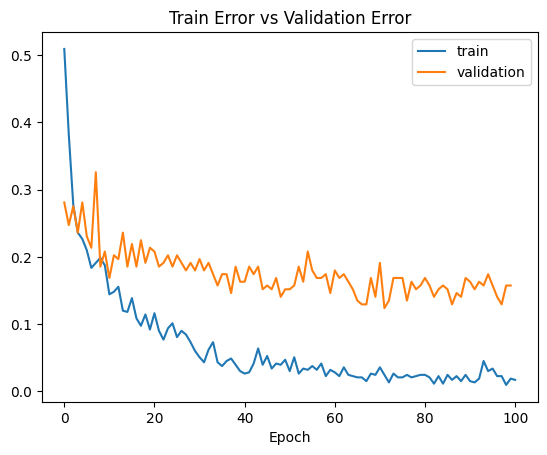

In [ ]:
plt.title("Train Error vs Validation Error")
e1 = [i for i in errors_t]
l1 = [i for i in errors_v]
plt.plot(e1, label="train")
plt.plot(l1, label='validation')
plt.xlabel("Epoch")
plt.legend(loc='best')

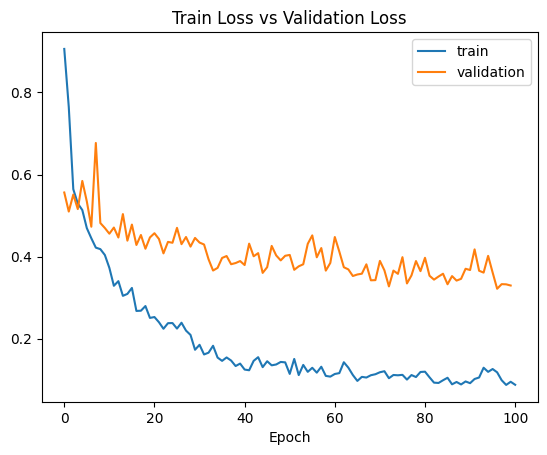

In [ ]:
plt.title("Train Loss vs Validation Loss")
e2 = [i for i in losses_t]
l2 = [i for i in losses_v]
plt.plot(e2, label="train")
plt.plot(l2, label='validation')
plt.xlabel("Epoch")
plt.legend(loc='best')